In [ ]:
!pip install flair

In [1]:
# %%
from flair.data import Corpus
from flair.datasets import STACKOVERFLOW_NER


import flair
import logging
from pathlib import Path
from typing import Union
from flair.file_utils import cached_path

from flair.datasets import ColumnCorpus

log = logging.getLogger("flair")
class STACKOVERFLOW_NER(ColumnCorpus):
    def __init__(
            self,
            base_path: Union[str, Path] = None,
            tag_to_bioes: str = "ner",
            in_memory: bool = True,
            **corpusargs,
    ):
        """
        Initialize the STACKOVERFLOW_NER corpus. The first time you call this constructor it will automatically
        download the dataset.
        :param base_path: Default is None, meaning that corpus gets auto-downloaded and loaded. You can override this
        to point to a different folder but typically this should not be necessary.
        :param tag_to_bioes: NER by default, need not be changed, but you could also select 'pos' to predict
        POS tags instead
        :param in_memory: If True, keeps dataset in memory giving speedups in training.
        :param document_as_sequence: If True, all sentences of a document are read into a single Sentence object
        """
        if type(base_path) == str:
            base_path: Path = Path(base_path)

        """
        The Datasets are represented in the Conll format.
           In this format each line of the Dataset is in the following format:
           <word>+"\t"+<NE>"\t"+<word>+"\t"<markdown>
           The end of sentence is marked with an empty line.
           In each line NE represented the human annotated named entity 
           and <markdown> represented the code tags provided by the users who wrote the posts.
           """
        # column format
        columns = {0: "word", 1: "ner"}

        # this dataset name
        dataset_name = self.__class__.__name__.lower()

        # default dataset folder is the cache root
        if not base_path:
            base_path = Path(flair.cache_root) / "datasets"
        data_folder = base_path / dataset_name

        # download data if necessary
        STACKOVERFLOW_NER_path = "https://raw.githubusercontent.com/jeniyat/StackOverflowNER/master/resources/annotated_ner_data/StackOverflow/"

        # data validation
        ban_sentences = ["code omitted for annotation",
                           "omitted for annotation",
                           "CODE_BLOCK :",
                           "OP_BLOCK :",
                           "Question_URL :",
                           "Question_ID :"
                           ]
        ban_tags = ["Error_Name",
                "Keyboard_IP",
                "Value",
                "Output_Block"]
        entity_mapping = {"Library_Function": "Function",
                "Function_Name": "Function",
                "Class_Name": "Class",
                "Library_Class": "Class",
                "Organization": "Website",
                "Library_Variable": "Variable",
                "Variable_Name": "Variable"}
                
        files = ["train", "test", "dev"]

        for file in files:
            questions = 0
            answers = 0
            sentences = 0
            max_length = 0
            words = []
            tags = []
            lines_sentence = []

            cached_path(f"{STACKOVERFLOW_NER_path}{file}.txt", Path("datasets") / dataset_name)
            write_file = open(data_folder/ (file + "_clean.txt"), mode="w+")
            for line in open(data_folder/ (file + ".txt"), mode="r", encoding="utf-8"):
                if line.startswith("Question_ID"):
                    questions += 1

                if line.startswith("Answer_to_Question_ID"):
                    answers += 1

                line_values = line.strip().split()
                if len(line_values) < 2:
                    text = " ".join(w for w in words)
                    allowed = all([d not in text for d in ban_sentences])
                    if allowed and len(text) > 0:
                        sentences += 1
                        max_length = max(len(words), max_length)
                        for w, t in zip(words, tags):
                            write_file.write(w + "\t" + t + "\n")
                    write_file.write("\n")
                    words = []
                    tags = []
                    lines_sentence = []
                    continue
                words.append(line_values[0])
                ent_type = line_values[1]
                label_split = ent_type.split("-", 1)
                if len(label_split) > 1:
                    # ent_iob = label_split[0]
                    if label_split[1] in ban_tags:
                         ent_type = "O"
                tags.append(ent_type)
                lines_sentence.append(line)
            write_file.close()

            log.info(f"==========File {file} processed ==============")
            log.info(f"The longest sentences has {max_length} words.")
            log.info(f"Questions: {questions} and Answers: {answers}")
            log.info(f"Processed sentences: {sentences}.")

        super(STACKOVERFLOW_NER, self).__init__(
            data_folder,
            columns,
            train_file="train_clean.txt",
            test_file="test_clean.txt",
            dev_file="dev_clean.txt",
            tag_to_bioes=tag_to_bioes,
            encoding="utf-8",
            in_memory=in_memory,
            label_name_map=entity_mapping,
            **corpusargs
        )

corpus: Corpus = STACKOVERFLOW_NER()
print(corpus)

2021-05-02 10:54:47,981 ==========File train processed ==============
2021-05-02 10:54:47,982 The longest sentences has 92 words.
2021-05-02 10:54:47,982 Questions: 741 and Answers: 897
2021-05-02 10:54:47,987 Processed sentences: 9263.
2021-05-02 10:54:48,123 ==========File test processed ==============
2021-05-02 10:54:48,125 The longest sentences has 83 words.
2021-05-02 10:54:48,126 Questions: 249 and Answers: 315
2021-05-02 10:54:48,126 Processed sentences: 3108.
2021-05-02 10:54:48,244 ==========File dev processed ==============
2021-05-02 10:54:48,246 The longest sentences has 86 words.
2021-05-02 10:54:48,247 Questions: 247 and Answers: 289
2021-05-02 10:54:48,248 Processed sentences: 2936.
2021-05-02 10:54:48,249 Reading data from /root/.flair/datasets/stackoverflow_ner
2021-05-02 10:54:48,250 Train: /root/.flair/datasets/stackoverflow_ner/train_clean.txt
2021-05-02 10:54:48,251 Dev: /root/.flair/datasets/stackoverflow_ner/dev_clean.txt
2021-05-02 10:54:48,252 Test: /root/.fla

In [2]:
# %%
# 2. make the tag dictionary from the corpus
tag_type = 'ner'
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)

Dictionary with 82 tags: <unk>, O, S-Data_Structure, S-Application, S-Code_Block, B-Code_Block, E-Code_Block, B-Application, E-Application, S-Function, S-Data_Type, S-Language, S-Library, S-Variable, S-Device, S-User_Name, S-User_Interface_Element, S-Class, B-Function, I-Function, E-Function, I-Code_Block, S-Website, B-Library, E-Library, S-Version, B-Class, E-Class, S-File_Name, B-User_Name


In [3]:
# %%
# 3. initialize embeddings
from flair.embeddings import WordEmbeddings, FlairEmbeddings, ELMoEmbeddings, StackedEmbeddings, PooledFlairEmbeddings, TransformerWordEmbeddings

embedding_types = [

    # WordEmbeddings('glove'),
    # ELMoEmbeddings(),
    # comment in this line to use character embeddings
    # CharacterEmbeddings(),

    # comment in these lines to use flair embeddings
    # FlairEmbeddings('news-forward'),
    # FlairEmbeddings('news-backward'),
    # PooledFlairEmbeddings('news-backward'),
    TransformerWordEmbeddings('bert-base-cased')
]
embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
# %%
# 4. initialize sequence tagger
from flair.models import SequenceTagger

tagger: SequenceTagger = SequenceTagger(hidden_size=64,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True,
                                        dropout=0.1,
                                        word_dropout=0,
                                        locked_dropout=0,
                                        train_initial_hidden_state=True,
                                        use_rnn=True,
                                        rnn_layers=1)

# %%
# 5. initialize trainer
from flair.trainers import ModelTrainer
from torch.optim.adam import Adam
from torch.optim.lr_scheduler import OneCycleLR

trainer: ModelTrainer = ModelTrainer(tagger, corpus, optimizer=Adam)

/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[1.4454397707459274e-07]
[1.7378008287493754e-07]
[2.0892961308540395e-07]
[2.51188643150958e-07]
[3.019951720402016e-07]
[3.6307805477010137e-07]
[4.36515832240166e-07]
[5.248074602497725e-07]
[6.309573444801933e-07]
[7.585775750291837e-07]
[9.120108393559096e-07]
[1.096478196143185e-06]
[1.3182567385564074e-06]
[1.5848931924611132e-06]
[1.9054607179632473e-06]
[2.2908676527677735e-06]
[2.754228703338166e-06]
[3.311311214825911e-06]
[3.981071705534973e-06]
[4.7863009232263826e-06]
[5.754399373371569e-06]
[6.918309709189365e-06]
[8.317637711026708e-06]
[9.999999999999999e-06]
[1.202264434617413e-05]
[1.4454397707459279e-05]
[1.737800828749376e-05]
[2.0892961308540385e-05]
[2.5118864315095795e-05]
[3.019951720402016e-05]
[3.630780547701014e-05]
[4.365158322401661e-05]
[5.248074602497728e-05]
[6.309573444801929e-05]
[7.585775750291836e-05]
[9.120108393559096e-05]
[0.00010964781961431851]
[0.00013182567385564074]
[0.0001584893192461114]
[0.00019054607179632462]
[0.00022908676527677726]
[0

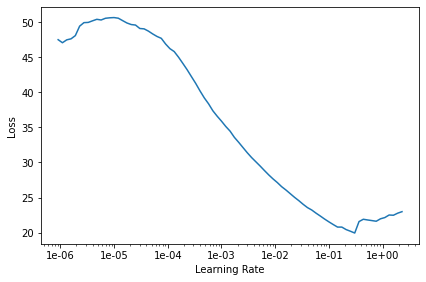

2021-04-28 08:43:04,695 ----------------------------------------------------------------------------------------------------
2021-04-28 08:43:04,696 Testing using best model ...
2021-04-28 08:43:04,697 loading file resources/taggers/soft_ner/best-model.pt


RuntimeError: CUDA out of memory. Tried to allocate 1.35 GiB (GPU 0; 15.90 GiB total capacity; 12.65 GiB already allocated; 409.50 MiB free; 14.84 GiB reserved in total by PyTorch)

In [ ]:
# %%
trainer.find_learning_rate('resources/taggers/soft_ner')
# %%
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_learning_rate("resources/taggers/soft_ner/learning_rate.tsv")

# %%
# 7. Eval training

trainer.final_test('resources/taggers/soft_ner',
                    eval_mini_batch_size=512)

In [ ]:
# %%
from flair.training_utils import AnnealOnPlateau
# 6. start training
trainer.train('resources/taggers/soft_ner',
            learning_rate=0.5,
            mini_batch_size=64,
            max_epochs=20,
            monitor_train=True,
            monitor_test=True,
            weight_decay=0.01,
            scheduler=AnnealOnPlateau,
            patience=1,
            anneal_with_restarts=True,
            batch_growth_annealing=True)

2021-04-28 08:43:50,140 ----------------------------------------------------------------------------------------------------
2021-04-28 08:43:50,142 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (linear): Linear(in_features=4196, out_features=82, bias=True)
  (beta): 1.0
 